Importing necessary libraries and downloading the historic data for Axis Bank and IDBI Bank

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [ ]:
axis = yf.download("AXISBANK.NS", start="2022-06-01", end="2023-05-31")
idbi = yf.download("IDBI.NS", start="2022-06-01", end="2023-05-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


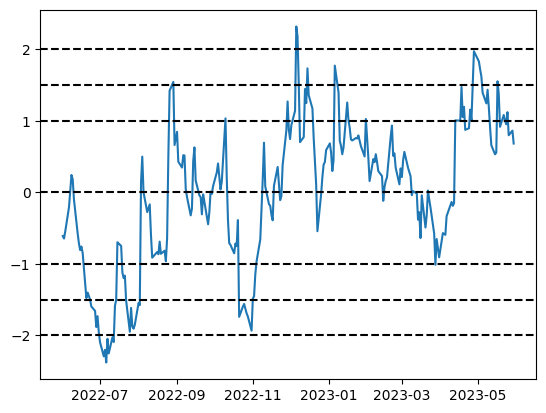

In [ ]:
ratio = idbi['Close'] / axis['Close']
ratio = (ratio - ratio.mean()) / ratio.std()
plt.plot(ratio.index, ratio)
plt.axhline(2, linestyle='dashed', color='black')
plt.axhline(-2, linestyle='dashed', color='black')
plt.axhline(0, linestyle='dashed', color='black')
plt.axhline(1, linestyle='dashed', color='black')
plt.axhline(-1, linestyle='dashed', color='black')
plt.axhline(1.5, linestyle='dashed', color='black')
plt.axhline(-1.5, linestyle='dashed', color='black')

Verifying whether the ratio of these stocks is stationary by using ADF test

In [ ]:
adf = adfuller(ratio)
print('ADF Test Statistic: %f' % adf[0])
print('5%% Critical Value: %f' % adf[4]['5%'])
print('p-value: %f' % adf[1])

ADF Test Statistic: -2.956400
5% Critical Value: -2.873362
p-value: 0.039172


Since p-value is less than 0.05, we conclude that this pair of stocks is indeed stationary. Now let us generate buy and sell signals.

When the z-score goes above the 1.5 std deviation line, we predict that it will revert to its mean (mean reversion strategy). Hence, to gain profit, we must go long on the stock which is in numerator (IDBI bank) and short on the other stock (Axis Bank). Later, when the z-score reaches the mean, we perform the opposite trade and gain the profits. We do exactly opposite in the case when when z-score goes below -1.5 std deviation line.

In [ ]:
sell_signals = []  # sell axis stocks and buy idbi
buy_signals = []  # sell idbi and buy axis
signals = []

status = ''
for i in ratio.index:
    if (ratio[i] > 1.5) and status != 'SELL':
        sell_signals.append(i)
        signals.append((i,'SELL'))
        status = 'SELL'
    elif (ratio[i] < 0) and status == 'SELL':
        buy_signals.append(i)
        signals.append((i, 'BUY'))
        status = 'MEAN'
    elif (ratio[i] > 0) and status == 'BUY':
        sell_signals.append(i)
        signals.append((i, 'SELL'))
        status = 'MEAN'
    elif (ratio[i] < -1.5) and status != 'BUY':
        buy_signals.append(i)
        signals.append((i,'BUY'))
        status = 'BUY'
    else:
        signals.append((i, 'NONE'))

print(sell_signals)
print(buy_signals)

[Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-29 00:00:00'), Timestamp('2022-11-09 00:00:00'), Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-04-28 00:00:00')]
[Timestamp('2022-06-24 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-12-23 00:00:00'), Timestamp('2023-02-14 00:00:00')]


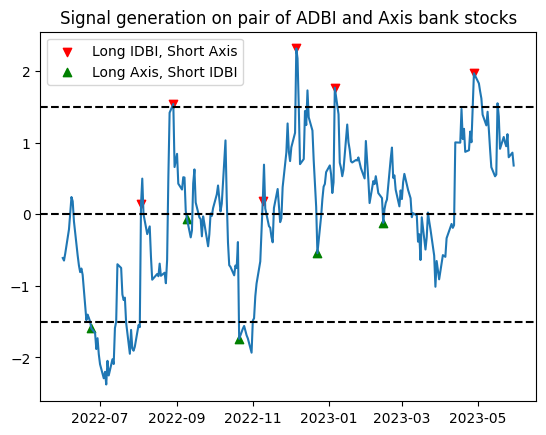

In [ ]:
plt.figure()
plt.title("Signal generation on pair of ADBI and Axis bank stocks")
plt.plot(ratio.index, ratio)
plt.scatter(sell_signals, ratio[sell_signals], marker='v', color='r', label='Long IDBI, Short Axis')
plt.scatter(buy_signals, ratio[buy_signals], marker='^', color='g', label='Long Axis, Short IDBI')
plt.axhline(1.5, linestyle='dashed', color='black')
plt.axhline(-1.5, linestyle='dashed', color='black')
plt.axhline(0, linestyle='dashed', color='black')
plt.legend()

Initial capital is 50 lakh rupees. Assuming that we have invested equal amount into both stocks, we will calculate the net returns. When we go short on a particular stock, we are selling all the stocks we own, and with the capital we now have, we will use all of it to go long on the other stock

remaining capital = 226.82364654541016
current value = 10164997.306007385
returns = 103.29994612014772%


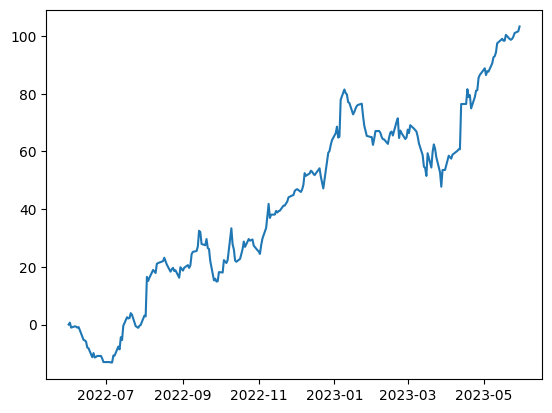

In [ ]:
capital = 50_00_000

n_idbi = (capital // 2) // idbi['Close'][0]
n_axis = (capital // 2) // axis['Close'][0]

capital -= n_idbi * idbi['Close'][0]
capital -= n_axis * axis['Close'][0]

index = []
returns = []

for i in signals:
    if (i[1] == 'SELL'):  # sell idbi and buy axis
        capital += n_idbi * idbi['Close'][i[0]]
        n_idbi = 0
        n_axis += capital // axis['Close'][i[0]]
        capital -= (capital // axis['Close'][i[0]]) * axis['Close'][i[0]]
    elif i[1] == 'BUY':
        capital += n_axis * axis['Close'][i[0]]
        n_axis = 0
        n_idbi += capital // idbi['Close'][i[0]]
        capital -= (capital // idbi['Close'][i[0]]) * idbi['Close'][i[0]]

    current_value = n_idbi * idbi['Close'][i[0]] + n_axis * axis['Close'][i[0]]

    returns.append((current_value / 50_00_000 - 1) * 100)
    index.append(i[0])

current_value = n_idbi * idbi['Close'][-1] + n_axis * axis['Close'][-1] + capital
print(f"remaining capital = {capital}")
print(f"current value = {current_value}")
print(f"returns = {((current_value) / 50_00_000 - 1) * 100}%")
plt.plot(index, returns)

Performing same strategies, except signals are generated for +-1 standard deviation

[Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-10-10 00:00:00'), Timestamp('2022-11-09 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-04-13 00:00:00')]
[Timestamp('2022-06-20 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-10-12 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-12-23 00:00:00'), Timestamp('2023-02-14 00:00:00'), Timestamp('2023-03-28 00:00:00')]


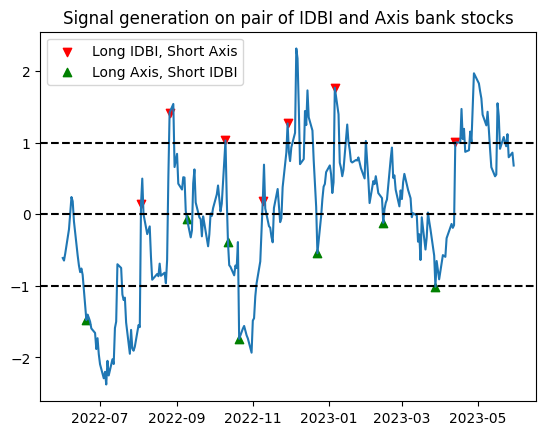

In [ ]:
sell_signals = []  # sell axis stocks and buy idbi
buy_signals = []  # sell idbi and buy axis
signals = []

status = ''
for i in ratio.index:
    if (ratio[i] > 1) and status != 'SELL':
        sell_signals.append(i)
        signals.append((i,'SELL'))
        status = 'SELL'
    elif (ratio[i] < 0) and status == 'SELL':
        buy_signals.append(i)
        signals.append((i, 'BUY'))
        status = 'MEAN'
    elif (ratio[i] > 0) and status == 'BUY':
        sell_signals.append(i)
        signals.append((i, 'SELL'))
        status = 'MEAN'
    elif (ratio[i] < -1) and status != 'BUY':
        buy_signals.append(i)
        signals.append((i,'BUY'))
        status = 'BUY'
    else:
        signals.append((i, 'NONE'))

plt.figure()
plt.title("Signal generation on pair of IDBI and Axis bank stocks")
plt.plot(ratio.index, ratio)
plt.scatter(sell_signals, ratio[sell_signals], marker='v', color='r', label='Long IDBI, Short Axis')
plt.scatter(buy_signals, ratio[buy_signals], marker='^', color='g', label='Long Axis, Short IDBI')
plt.axhline(1, linestyle='dashed', color='black')
plt.axhline(-1, linestyle='dashed', color='black')
plt.axhline(0, linestyle='dashed', color='black')
plt.legend()

print(sell_signals)
print(buy_signals)

remaining capital = 45.912445068359375
current value = 10488236.649017334
returns = 109.76565122924806%


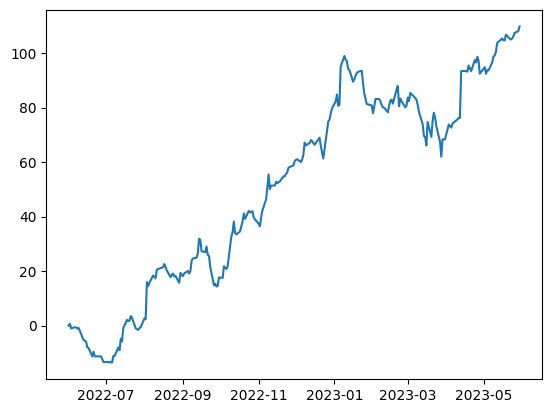

In [ ]:
capital = 50_00_000

n_idbi = (capital // 2) // idbi['Close'][0]
n_axis = (capital // 2) // axis['Close'][0]

capital -= n_idbi * idbi['Close'][0]
capital -= n_axis * axis['Close'][0]

index = []
returns = []

for i in signals:
    if (i[1] == 'SELL'):  # sell idbi and buy axis
        capital += n_idbi * idbi['Close'][i[0]]
        n_idbi = 0
        n_axis += capital // axis['Close'][i[0]]
        capital -= (capital // axis['Close'][i[0]]) * axis['Close'][i[0]]
    elif i[1] == 'BUY':
        capital += n_axis * axis['Close'][i[0]]
        n_axis = 0
        n_idbi += capital // idbi['Close'][i[0]]
        capital -= (capital // idbi['Close'][i[0]]) * idbi['Close'][i[0]]

    current_value = n_idbi * idbi['Close'][i[0]] + n_axis * axis['Close'][i[0]]

    returns.append((current_value / 50_00_000 - 1) * 100)
    index.append(i[0])

current_value = n_idbi * idbi['Close'][-1] + n_axis * axis['Close'][-1] + capital
print(f"remaining capital = {capital}")
print(f"current value = {current_value}")
print(f"returns = {((current_value + capital) / 50_00_000 - 1) * 100}%")
plt.plot(index, returns)

Performing same strategies, except signals are generated for +-2 standard deviation

[Timestamp('2022-08-03 00:00:00'), Timestamp('2022-12-06 00:00:00')]
[Timestamp('2022-07-01 00:00:00'), Timestamp('2022-12-23 00:00:00')]


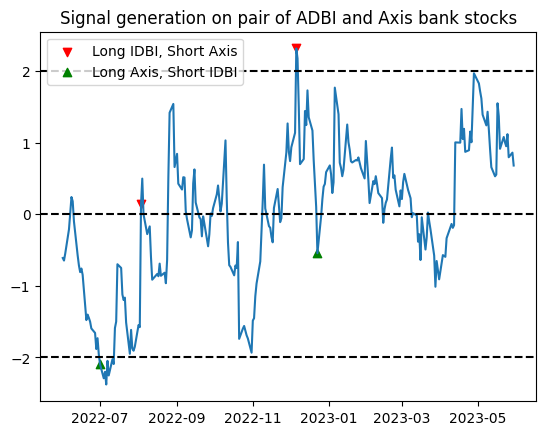

In [ ]:
sell_signals = []  # sell axis stocks and buy idbi
buy_signals = []  # sell idbi and buy axis
signals = []

status = ''
for i in ratio.index:
    if (ratio[i] > 2) and status != 'SELL':
        sell_signals.append(i)
        signals.append((i,'SELL'))
        status = 'SELL'
    elif (ratio[i] < 0) and status == 'SELL':
        buy_signals.append(i)
        signals.append((i, 'BUY'))
        status = 'MEAN'
    elif (ratio[i] > 0) and status == 'BUY':
        sell_signals.append(i)
        signals.append((i, 'SELL'))
        status = 'MEAN'
    elif (ratio[i] < -2) and status != 'BUY':
        buy_signals.append(i)
        signals.append((i,'BUY'))
        status = 'BUY'
    else:
        signals.append((i, 'NONE'))

plt.figure()
plt.title("Signal generation on pair of ADBI and Axis bank stocks")
plt.plot(ratio.index, ratio)
plt.scatter(sell_signals, ratio[sell_signals], marker='v', color='r', label='Long IDBI, Short Axis')
plt.scatter(buy_signals, ratio[buy_signals], marker='^', color='g', label='Long Axis, Short IDBI')
plt.axhline(2, linestyle='dashed', color='black')
plt.axhline(-2, linestyle='dashed', color='black')
plt.axhline(0, linestyle='dashed', color='black')
plt.legend()

print(sell_signals)
print(buy_signals)


remaining capital = 1.6637115478515625
current value = 8305713.094558716
returns = 66.11429516540528%


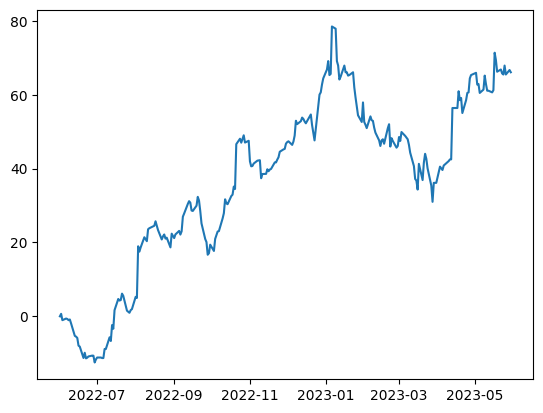

In [ ]:
capital = 50_00_000

n_idbi = (capital // 2) // idbi['Close'][0]
n_axis = (capital // 2) // axis['Close'][0]

capital -= n_idbi * idbi['Close'][0]
capital -= n_axis * axis['Close'][0]

index = []
returns = []

for i in signals:
    if (i[1] == 'SELL'):  # sell idbi and buy axis
        capital += n_idbi * idbi['Close'][i[0]]
        n_idbi = 0
        n_axis += capital // axis['Close'][i[0]]
        capital -= (capital // axis['Close'][i[0]]) * axis['Close'][i[0]]
    elif i[1] == 'BUY':
        capital += n_axis * axis['Close'][i[0]]
        n_axis = 0
        n_idbi += capital // idbi['Close'][i[0]]
        capital -= (capital // idbi['Close'][i[0]]) * idbi['Close'][i[0]]

    current_value = n_idbi * idbi['Close'][i[0]] + n_axis * axis['Close'][i[0]]

    returns.append((current_value / 50_00_000 - 1) * 100)
    index.append(i[0])

current_value = n_idbi * idbi['Close'][-1] + n_axis * axis['Close'][-1] + capital
print(f"remaining capital = {capital}")
print(f"current value = {current_value}")
print(f"returns = {((current_value + capital) / 50_00_000 - 1) * 100}%")
plt.plot(index, returns)